# import librairies

In [1]:
# import standard librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import datetime
import os
from tqdm.notebook import tqdm
import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import brute
import time
import random

# from src.utils.profiles import generate_dep_Pax_Counters
# from src.utils.profiles_from_schedule import (
#     generate_dep_Pax_Counters as custom_generate_dep_Pax_Counters,
# )

# from src.simfunc.KIX_T1d import KIX_T1d, univariate_cost_function_generator_T1d_N
# from src.simfunc.KIX_T1d_CUSBD import (
#     KIX_T1d_CUSBD,
#     univariate_cost_function_generator_T1d_CUSBD_N,
# )

from collections import Counter
import socket
import time

import ray

ray.init()

print(
    """This cluster consists of
    {} nodes in total
    {} CPU resources in total
""".format(
        len(ray.nodes()), ray.cluster_resources()["CPU"]
    )
)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2


# Rule definition

In [4]:
# convenience functions for plotting
def minutes_to_hms(minutes):
    if np.isnan(minutes):
        hms = np.nan
    else:
        hms = "{0:s} {1:0=2d}:{2:0=2d}:{3:0=2d}".format(
            "2020-10-13",
            int((minutes % 1440) // 60),
            int(minutes % 60),
            int((minutes % 1) * 60),
        )
    return hms


# timing function for graphs
def counter_timing_func(
    t: float,
    start_time: float = 2.5,
    onecounter_time: float = 0.75,
    base_n_counter: int = 4,
    **unused,
):
    y = 0
    if onecounter_time < t <= start_time:
        y = base_n_counter
    if 0 < t <= onecounter_time:
        y = 1
    return y


# counter = f(seats) for graphs
def counter_hour_number_func(
    seats: int,
    start_time: float = 2.5,
    onecounter_time: float = 0.75,
    base_n_counter: int = 4,
    seats_per_add_counter: int = 60,
    **unused,
):
    counter = max(
        base_n_counter,
        base_n_counter + 1 + ((seats - 201) // seats_per_add_counter),
    )

    y = counter * (start_time - onecounter_time) + 1 * onecounter_time

    z = y / seats

    return y

In [12]:
# define dct of edited check-in rule
dct_kwargs_rules = {
    "2.5": {
        "start_time": 2.5,
        "onecounter_time": 0.75,
        "base_n_counter": 4,
        "seats_per_add_counter": 60,
    },
    "3": {
        "start_time": 3,
        "onecounter_time": 0.75,
        "base_n_counter": 3,
        "seats_per_add_counter": 80,
    },
    "3.5": {
        "start_time": 3.5,
        "onecounter_time": 0.75,
        "base_n_counter": 3,
        "seats_per_add_counter": 120,
    },
    #    "4": {
    #        "start_time": 4,
    #        "onecounter_time": 0.75,
    #        "base_n_counter": 2,
    #        "seats_per_add_counter": 120,
    #    },
}

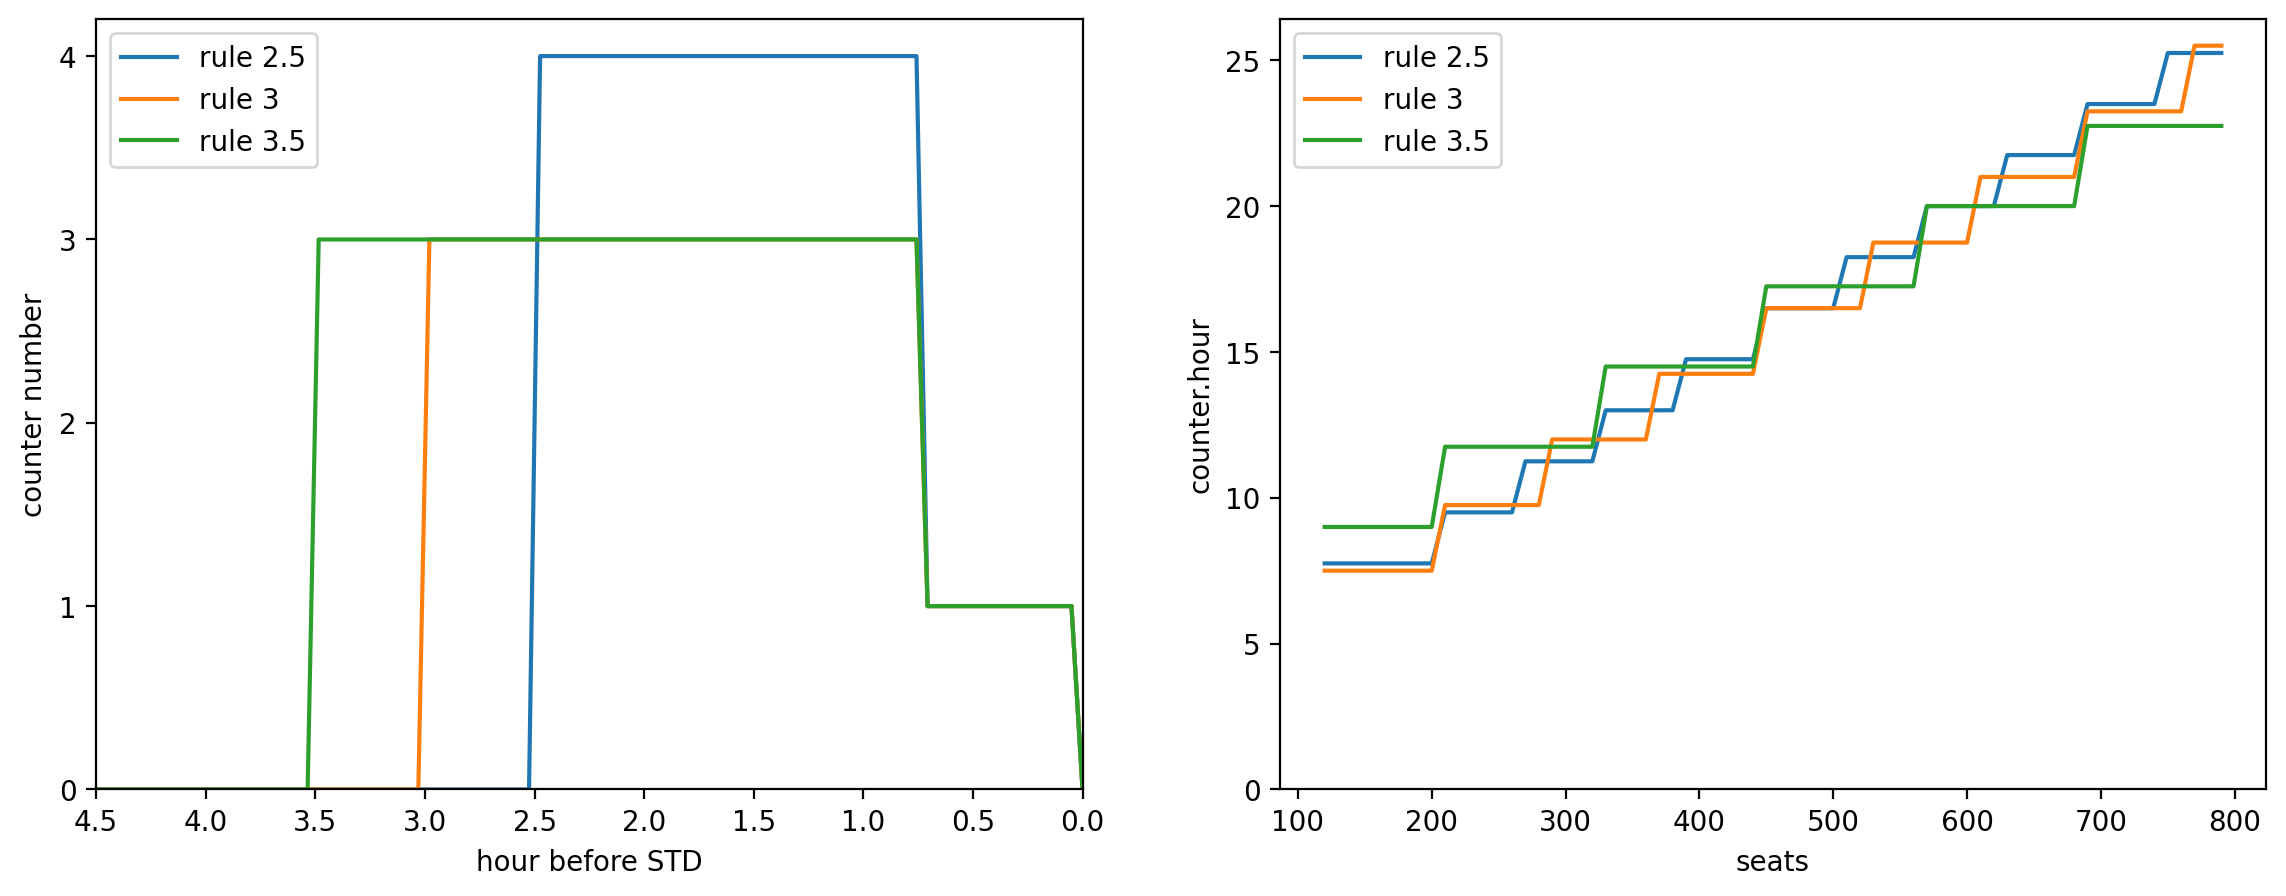

In [13]:
# plotting
x = np.linspace(0, 5, num=100)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

for case in dct_kwargs_rules.keys():
    y = [counter_timing_func(t, **dct_kwargs_rules[case]) for t in x]
    ax[0].plot(x, y, label="rule {}".format(case))

ax[0].set_xlim((4.5, 0))
ax[0].set_ylim(bottom=0)
ax[0].set(
    xlabel="hour before STD",
    ylabel="counter number",
    yticks=[0, 1, 2, 3, 4],
)
ax[0].legend()


x = [10 * i for i in range(12, 80)]
for case in dct_kwargs_rules.keys():
    y = [counter_hour_number_func(seats, **dct_kwargs_rules[case]) for seats in x]
    ax[1].plot(x, y, label="rule {}".format(case))

ax[1].set(xlabel="seats", ylabel="counter.hour")
ax[1].set_ylim(bottom=0)
ax[1].legend()

# Generate df_Pax and df_Counters for each rule

In [6]:
dct_df_Counters = {}

In [7]:
for case in dct_kwargs_rules.keys():
    df_Pax, dct_df_Counters[case] = generate_dep_Pax_Counters(
        target_peak=3880,
        terminal="T1",
        custom_counter_rule=True,
        **dct_kwargs_rules[case],
    )

NameError: name 'generate_dep_Pax_Counters' is not defined

In [ ]:
dct_df_plots = {}
for case in dct_df_Counters.keys():
    dct_df_plots[case] = dct_df_Counters[case].copy()
    dct_df_plots[case]["time"] = dct_df_plots[case].index
    dct_df_plots[case]["time"] = dct_df_plots[case]["time"].apply(
        lambda x: minutes_to_hms(5 * x)
    )
    dct_df_plots[case]["time"] = pd.to_datetime(dct_df_plots[case]["time"])
    dct_df_plots[case] = (
        dct_df_plots[case].set_index("time").resample("60S").ffill()[["total"]]
    )

<IPython.core.display.Javascript object>

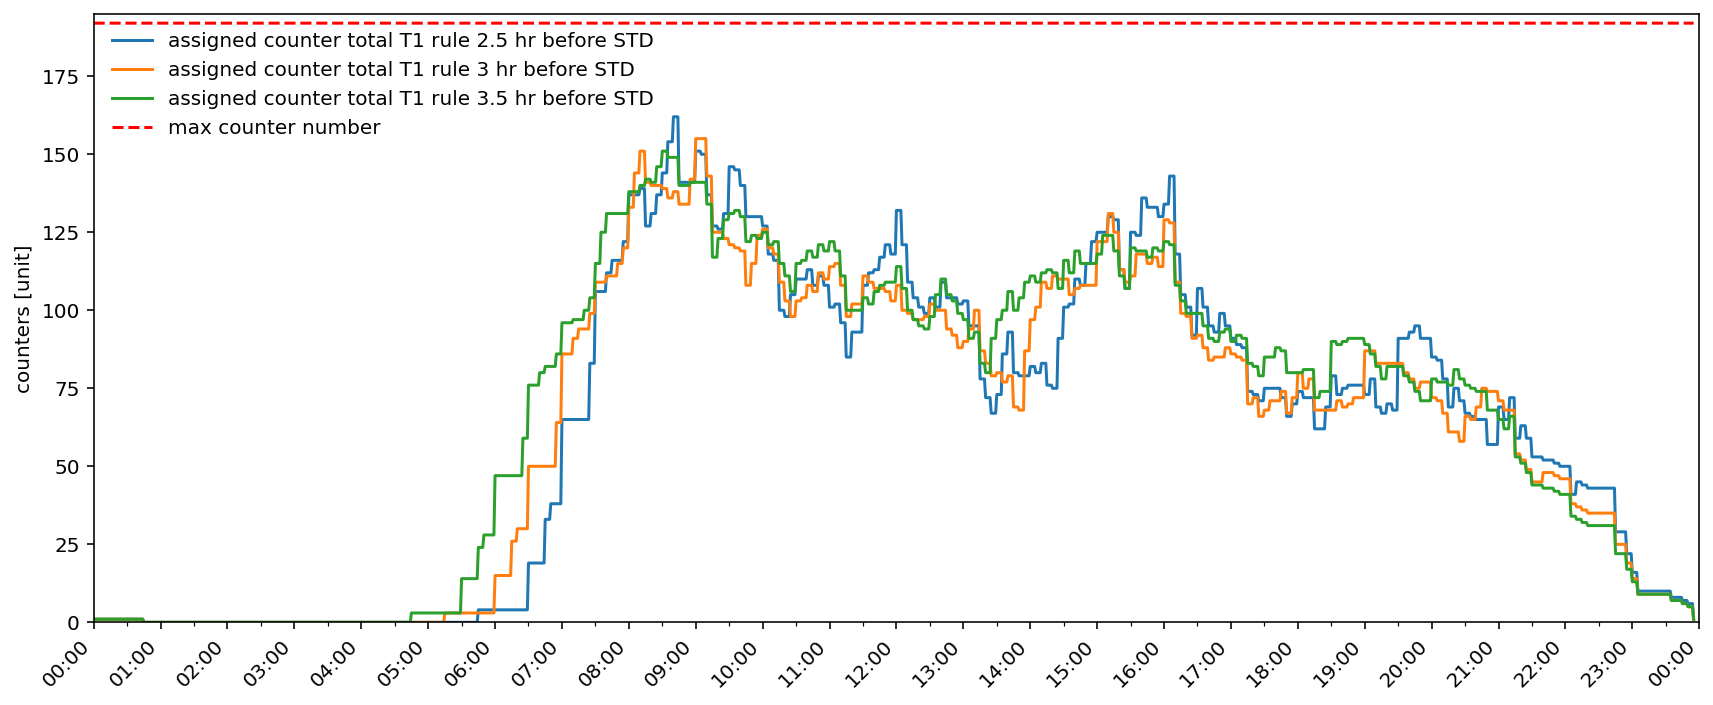

<IPython.core.display.Javascript object>

In [ ]:
# plot param
xmin = pd.to_datetime("2020-10-13 00:00:00")
xmax = pd.to_datetime("2020-10-14 00:00:00")
plt.rcParams.update({"figure.autolayout": True})
hours = mdates.HourLocator(interval=1)
half_hours = mdates.MinuteLocator(byminute=[0, 30], interval=1)
h_fmt = mdates.DateFormatter("%H:%M")

# actual plotting
fig, ax = plt.subplots(figsize=(12, 5))
for case in dct_df_plots.keys():
    ax.plot(
        dct_df_plots[case].index.to_list(),
        dct_df_plots[case]["total"].to_list(),
        label="assigned counter total T1 rule {} hr before STD".format(case),
    )

# max counter number
x = dct_df_plots["2.5"].index.to_list()
ax.plot(x, [192 for i in x], linestyle="--", color="red", label="max counter number")

# formatting
ax.set_xlim((xmin, xmax))
ax.set(ylabel="counters [unit]")
ax.set_xticks(dct_df_plots["2.5"].index.to_list())
ax.set_xticklabels(ax.get_xticks(), rotation=45, **{"horizontalalignment": "right"})
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
ax.xaxis.set_minor_locator(half_hours)
ax.legend(loc="upper left", frameon=False)

# scale y axis to leave more space
_, top = ax.get_ylim()
newtop = 1.20 * top
ax.set_ylim(bottom=0, top=195)

plt.show()

# run the simulations

## common imports

In [ ]:
# parameters from "assumption all dept.xlsx" on onedrive
path_onedrive = (
    r"/home/antoine/projects/KAPpaxsim/KAPpaxsim/data/raw/ADRM_param_full.xlsx"
)
df_param_onedrive = pd.read_excel(
    path_onedrive,
    sheet_name="Dynamic",
)

# generate df_set_param_T1d_from_drive from one drive excel file (assumptions all dept)
df_param_input = df_param_onedrive.set_index("item", drop=True, inplace=False)

# keep only T1 Int'l dep results
mask_T1d = (df_param_input["terminal"] == "T1") & (df_param_input["Direction"] == "D")
df_param_input_T1 = df_param_input[mask_T1d]

df_param_input_T1 = df_param_input_T1.drop(
    columns=["unit", "terminal", "type", "remarks", "Direction"]
)

# take values from assumption files and put them in a dictionnary
list_item = [
    "target_peak_STD",
    "Pt_checkin_1step_counter",
    "Pt_checkin_2step_counter",
    "N_kiosk",
    "Pt_kiosk",
    "N_security_lanes",
    "Pt_security_lanes",
    "N_emigration_counter",
    "Pt_emigration_counter",
    "N_emigration_self",
    "Pt_emigration_self",
    "modern_pax_ratio",
    "digital_pax_ratio",
    "premium_pax_ratio",
    "start_special_pax_ratio",
    "end_special_pax_ratio",
]

dct_set_param_T1d_from_drive = {
    item: list(df_param_input_T1.loc[item, :]) for item in list_item
}
len_dct_set_param_T1d_from_drive = len(dct_set_param_T1d_from_drive["target_peak_STD"])
dct_set_param_T1d_from_drive["target_peak"] = dct_set_param_T1d_from_drive.pop(
    "target_peak_STD"
)

# define values that are not in assumption files
dct_set_param_T1d_from_drive["freq"] = [
    "1min" for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["win"] = [
    15 for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_loading"] = [
    True for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["show_graph"] = [
    True for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_graph"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]
dct_set_param_T1d_from_drive["save_xls"] = [
    False for i in range(len_dct_set_param_T1d_from_drive)
]

df_set_param_T1d_from_drive = pd.DataFrame.from_dict(dct_set_param_T1d_from_drive)

df_set_param_T1d = df_set_param_T1d_from_drive.copy()
dct_set_param_T1d = dct_set_param_T1d_from_drive.copy()
# create the dictionary of param for the run from the dct_set_param
dct_run_param = {keys: value[5] for keys, value in dct_set_param_T1d.items()}

<IPython.core.display.Javascript object>

## run simulations

In [ ]:
# initialize parameters
dct_df_result = {}
dct_df_param = {}

dump_path = r"/home/antoine/projects/KAPpaxsim/KAPpaxsim/data/dump"

for case in dct_df_Counters.keys():
    dct_df_param[case] = dct_run_param.copy()
    dct_df_param[case]["path"] = dump_path
    dct_df_param[case]["df_Pax"] = df_Pax
    dct_df_param[case]["df_Counters"] = dct_df_Counters[case]
    dct_df_param[case].pop("target_peak", None)

<IPython.core.display.Javascript object>

Simulation running...: 100%|████████████████████████████████████████████████████████| 1440/1440 [04:38<00:00,  5.16it/s]


                                                path  \
0  /home/antoine/projects/KAPpaxsim/KAPpaxsim/dat...   

   Pt_checkin_1step_counter  Pt_checkin_2step_counter  N_kiosk  Pt_kiosk  \
0                  1.603333                      1.27     92.0       1.5   

   N_security_lanes  Pt_security_lanes  N_emigration_counter  \
0              22.0           0.233333                  26.0   

   Pt_emigration_counter  N_emigration_self  ...  premium_pax_ratio  \
0               0.383333               31.0  ...               0.05   

   start_special_pax_ratio  end_special_pax_ratio  freq  win  show_loading  \
0                      0.3                   0.95  1min   15          True   

  show_graph  save_graph  save_xls  call_n_iter  
0       True       False     False         None  

[1 rows x 23 columns]


Simulation running...: 100%|████████████████████████████████████████████████████████| 1440/1440 [04:14<00:00,  5.65it/s]


                                                path  \
0  /home/antoine/projects/KAPpaxsim/KAPpaxsim/dat...   

   Pt_checkin_1step_counter  Pt_checkin_2step_counter  N_kiosk  Pt_kiosk  \
0                  1.603333                      1.27     92.0       1.5   

   N_security_lanes  Pt_security_lanes  N_emigration_counter  \
0              22.0           0.233333                  26.0   

   Pt_emigration_counter  N_emigration_self  ...  premium_pax_ratio  \
0               0.383333               31.0  ...               0.05   

   start_special_pax_ratio  end_special_pax_ratio  freq  win  show_loading  \
0                      0.3                   0.95  1min   15          True   

  show_graph  save_graph  save_xls  call_n_iter  
0       True       False     False         None  

[1 rows x 23 columns]


Simulation running...: 100%|████████████████████████████████████████████████████████| 1440/1440 [04:06<00:00,  5.85it/s]


                                                path  \
0  /home/antoine/projects/KAPpaxsim/KAPpaxsim/dat...   

   Pt_checkin_1step_counter  Pt_checkin_2step_counter  N_kiosk  Pt_kiosk  \
0                  1.603333                      1.27     92.0       1.5   

   N_security_lanes  Pt_security_lanes  N_emigration_counter  \
0              22.0           0.233333                  26.0   

   Pt_emigration_counter  N_emigration_self  ...  premium_pax_ratio  \
0               0.383333               31.0  ...               0.05   

   start_special_pax_ratio  end_special_pax_ratio  freq  win  show_loading  \
0                      0.3                   0.95  1min   15          True   

  show_graph  save_graph  save_xls  call_n_iter  
0       True       False     False         None  

[1 rows x 23 columns]


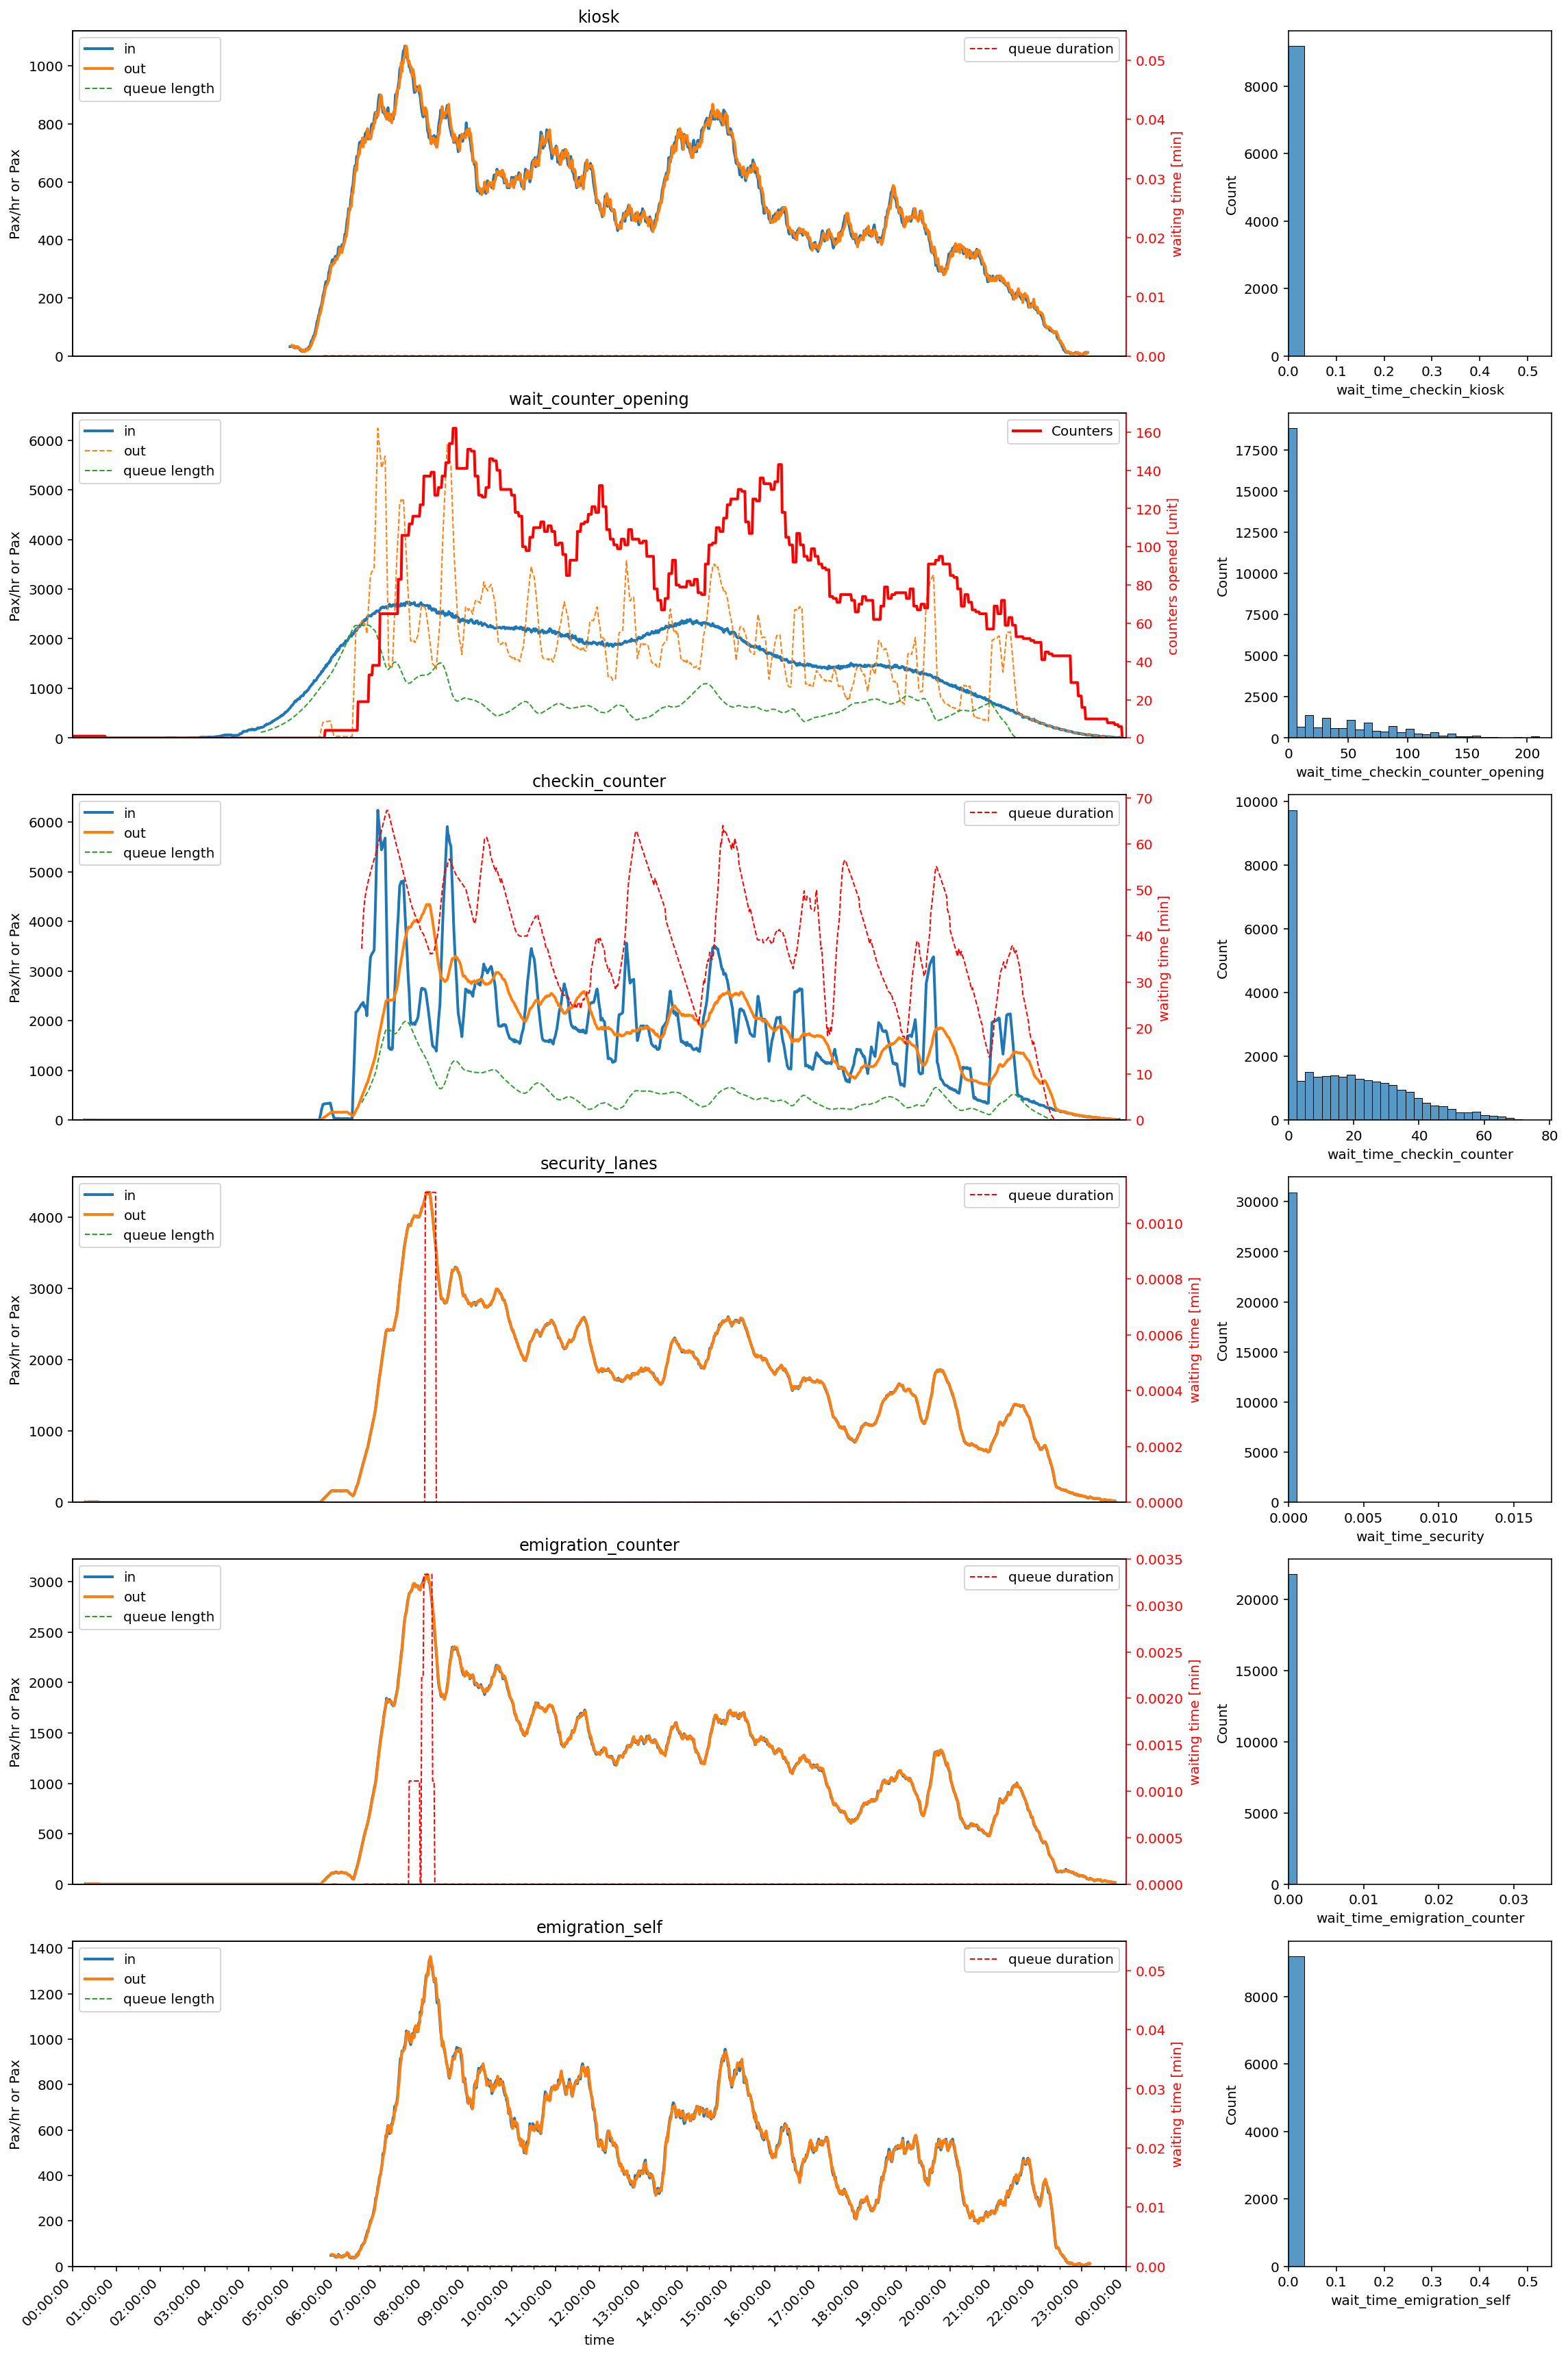

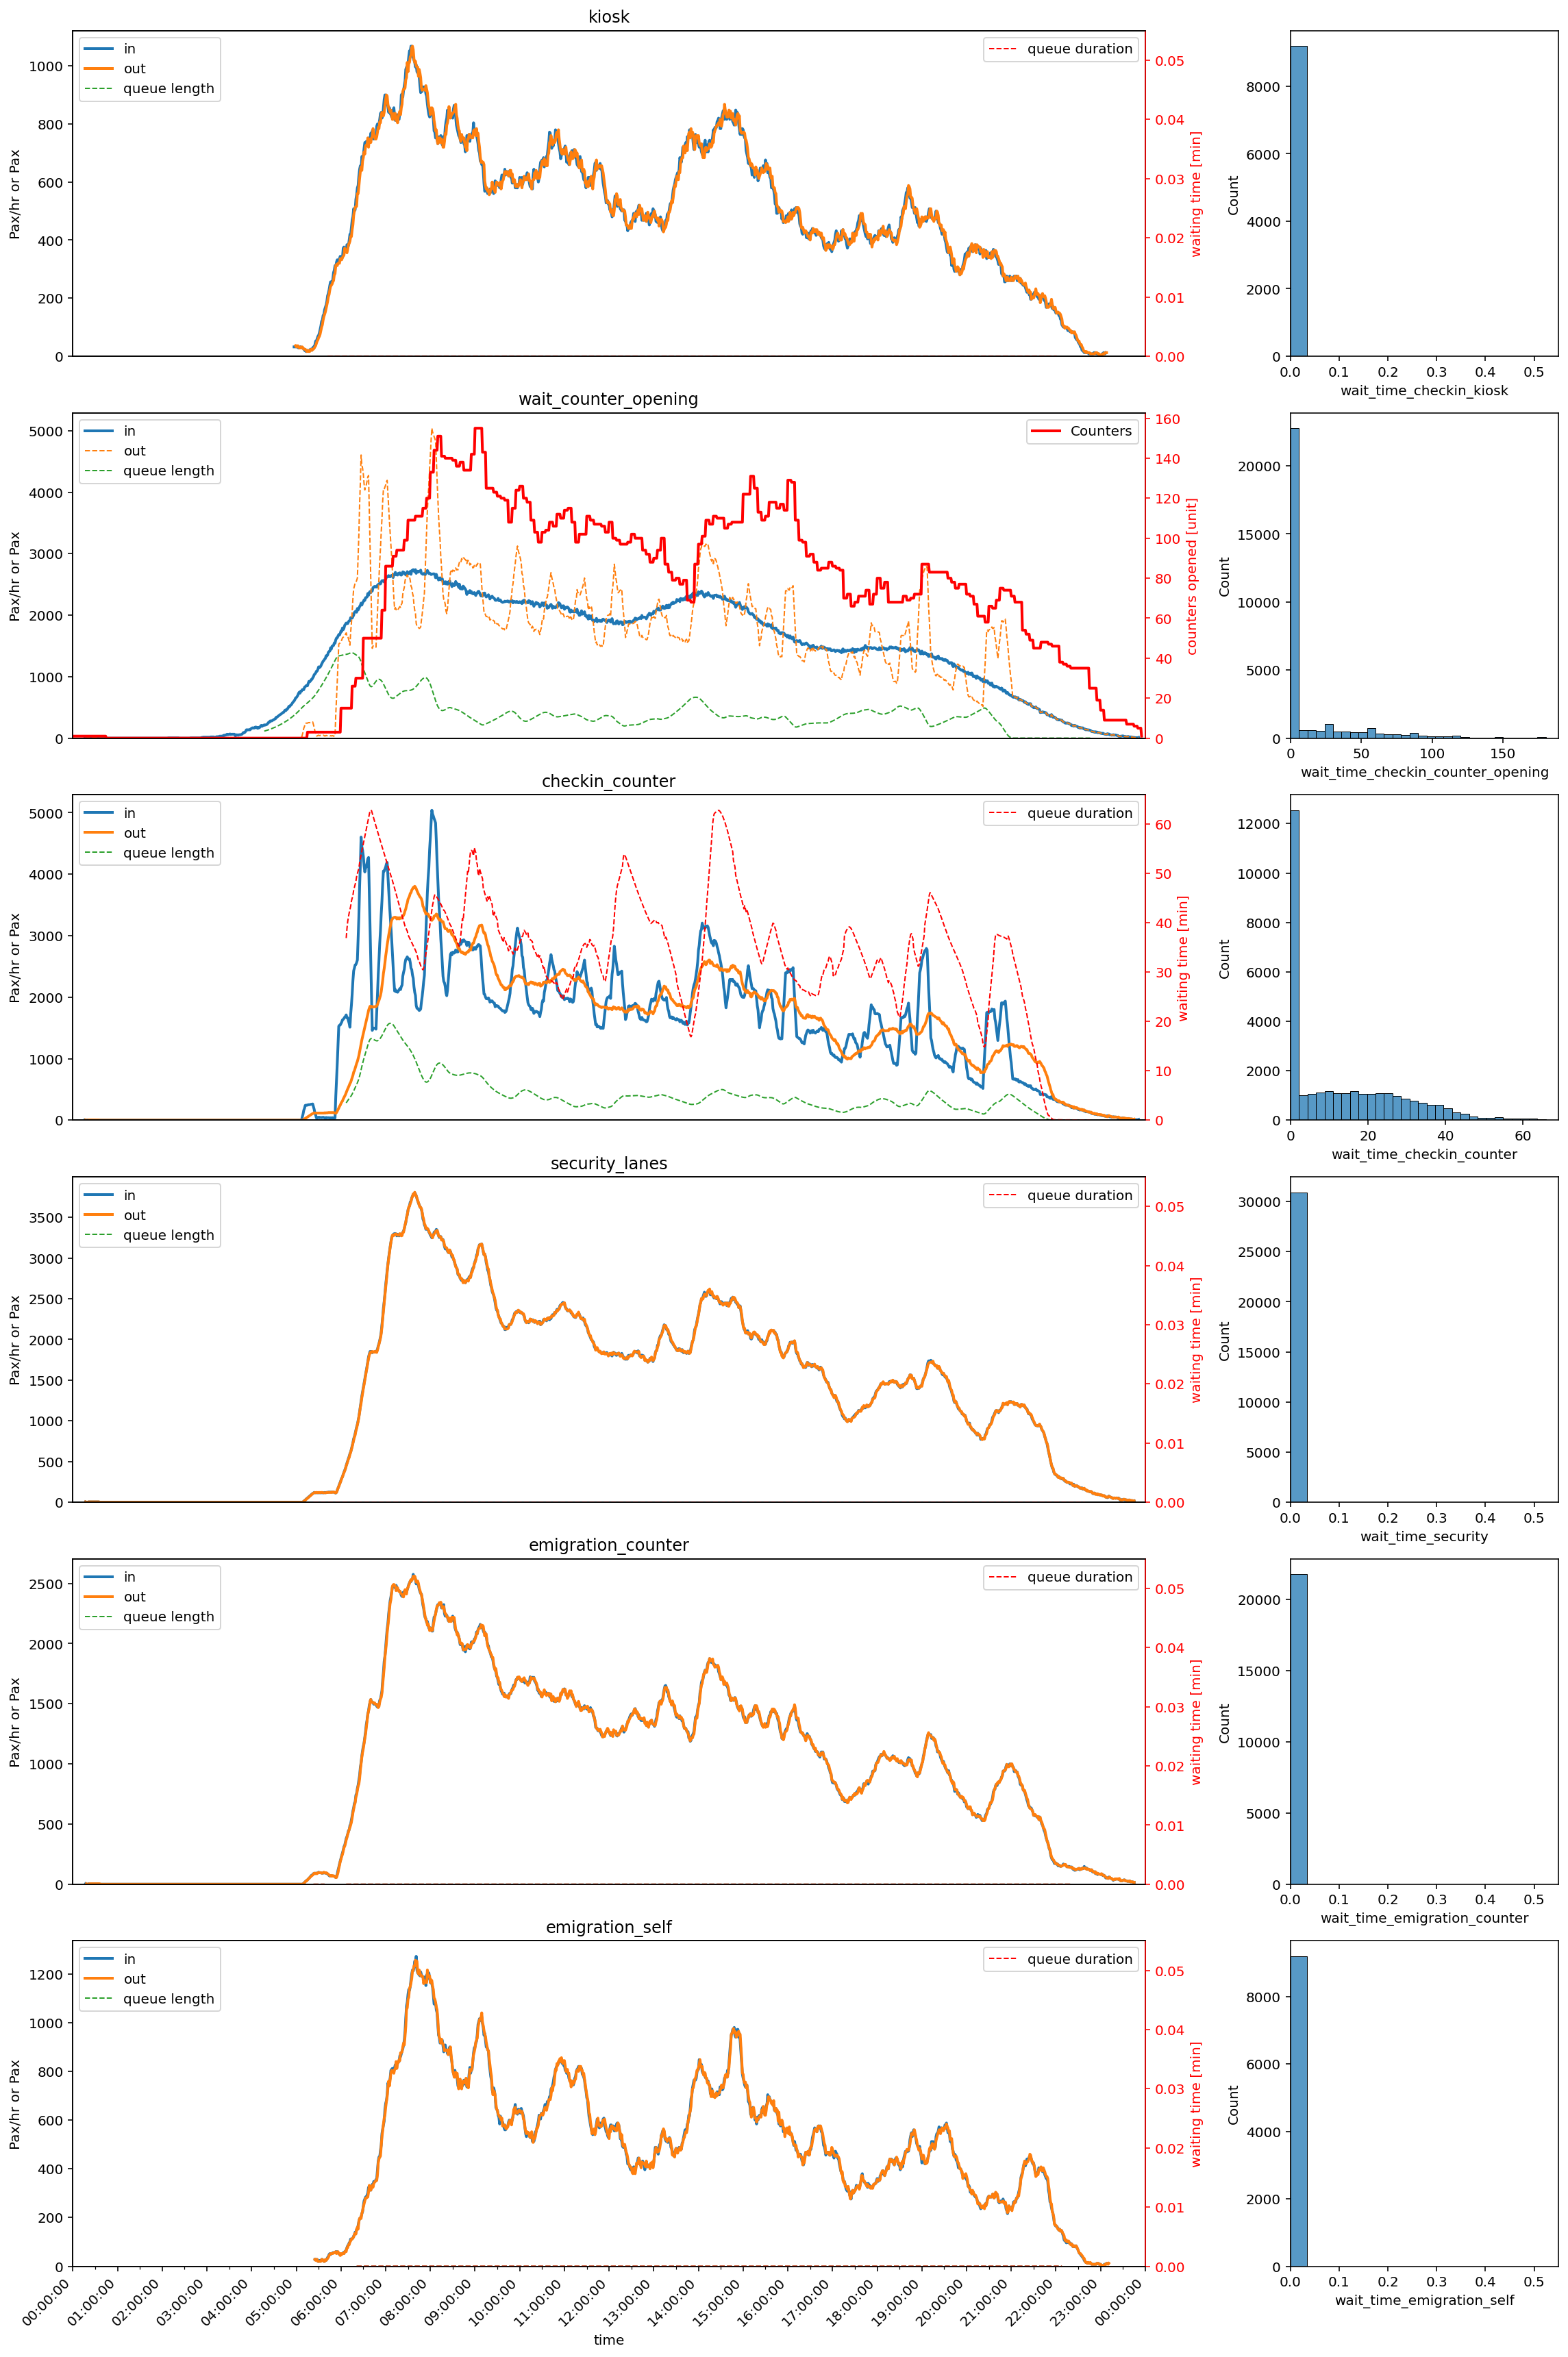

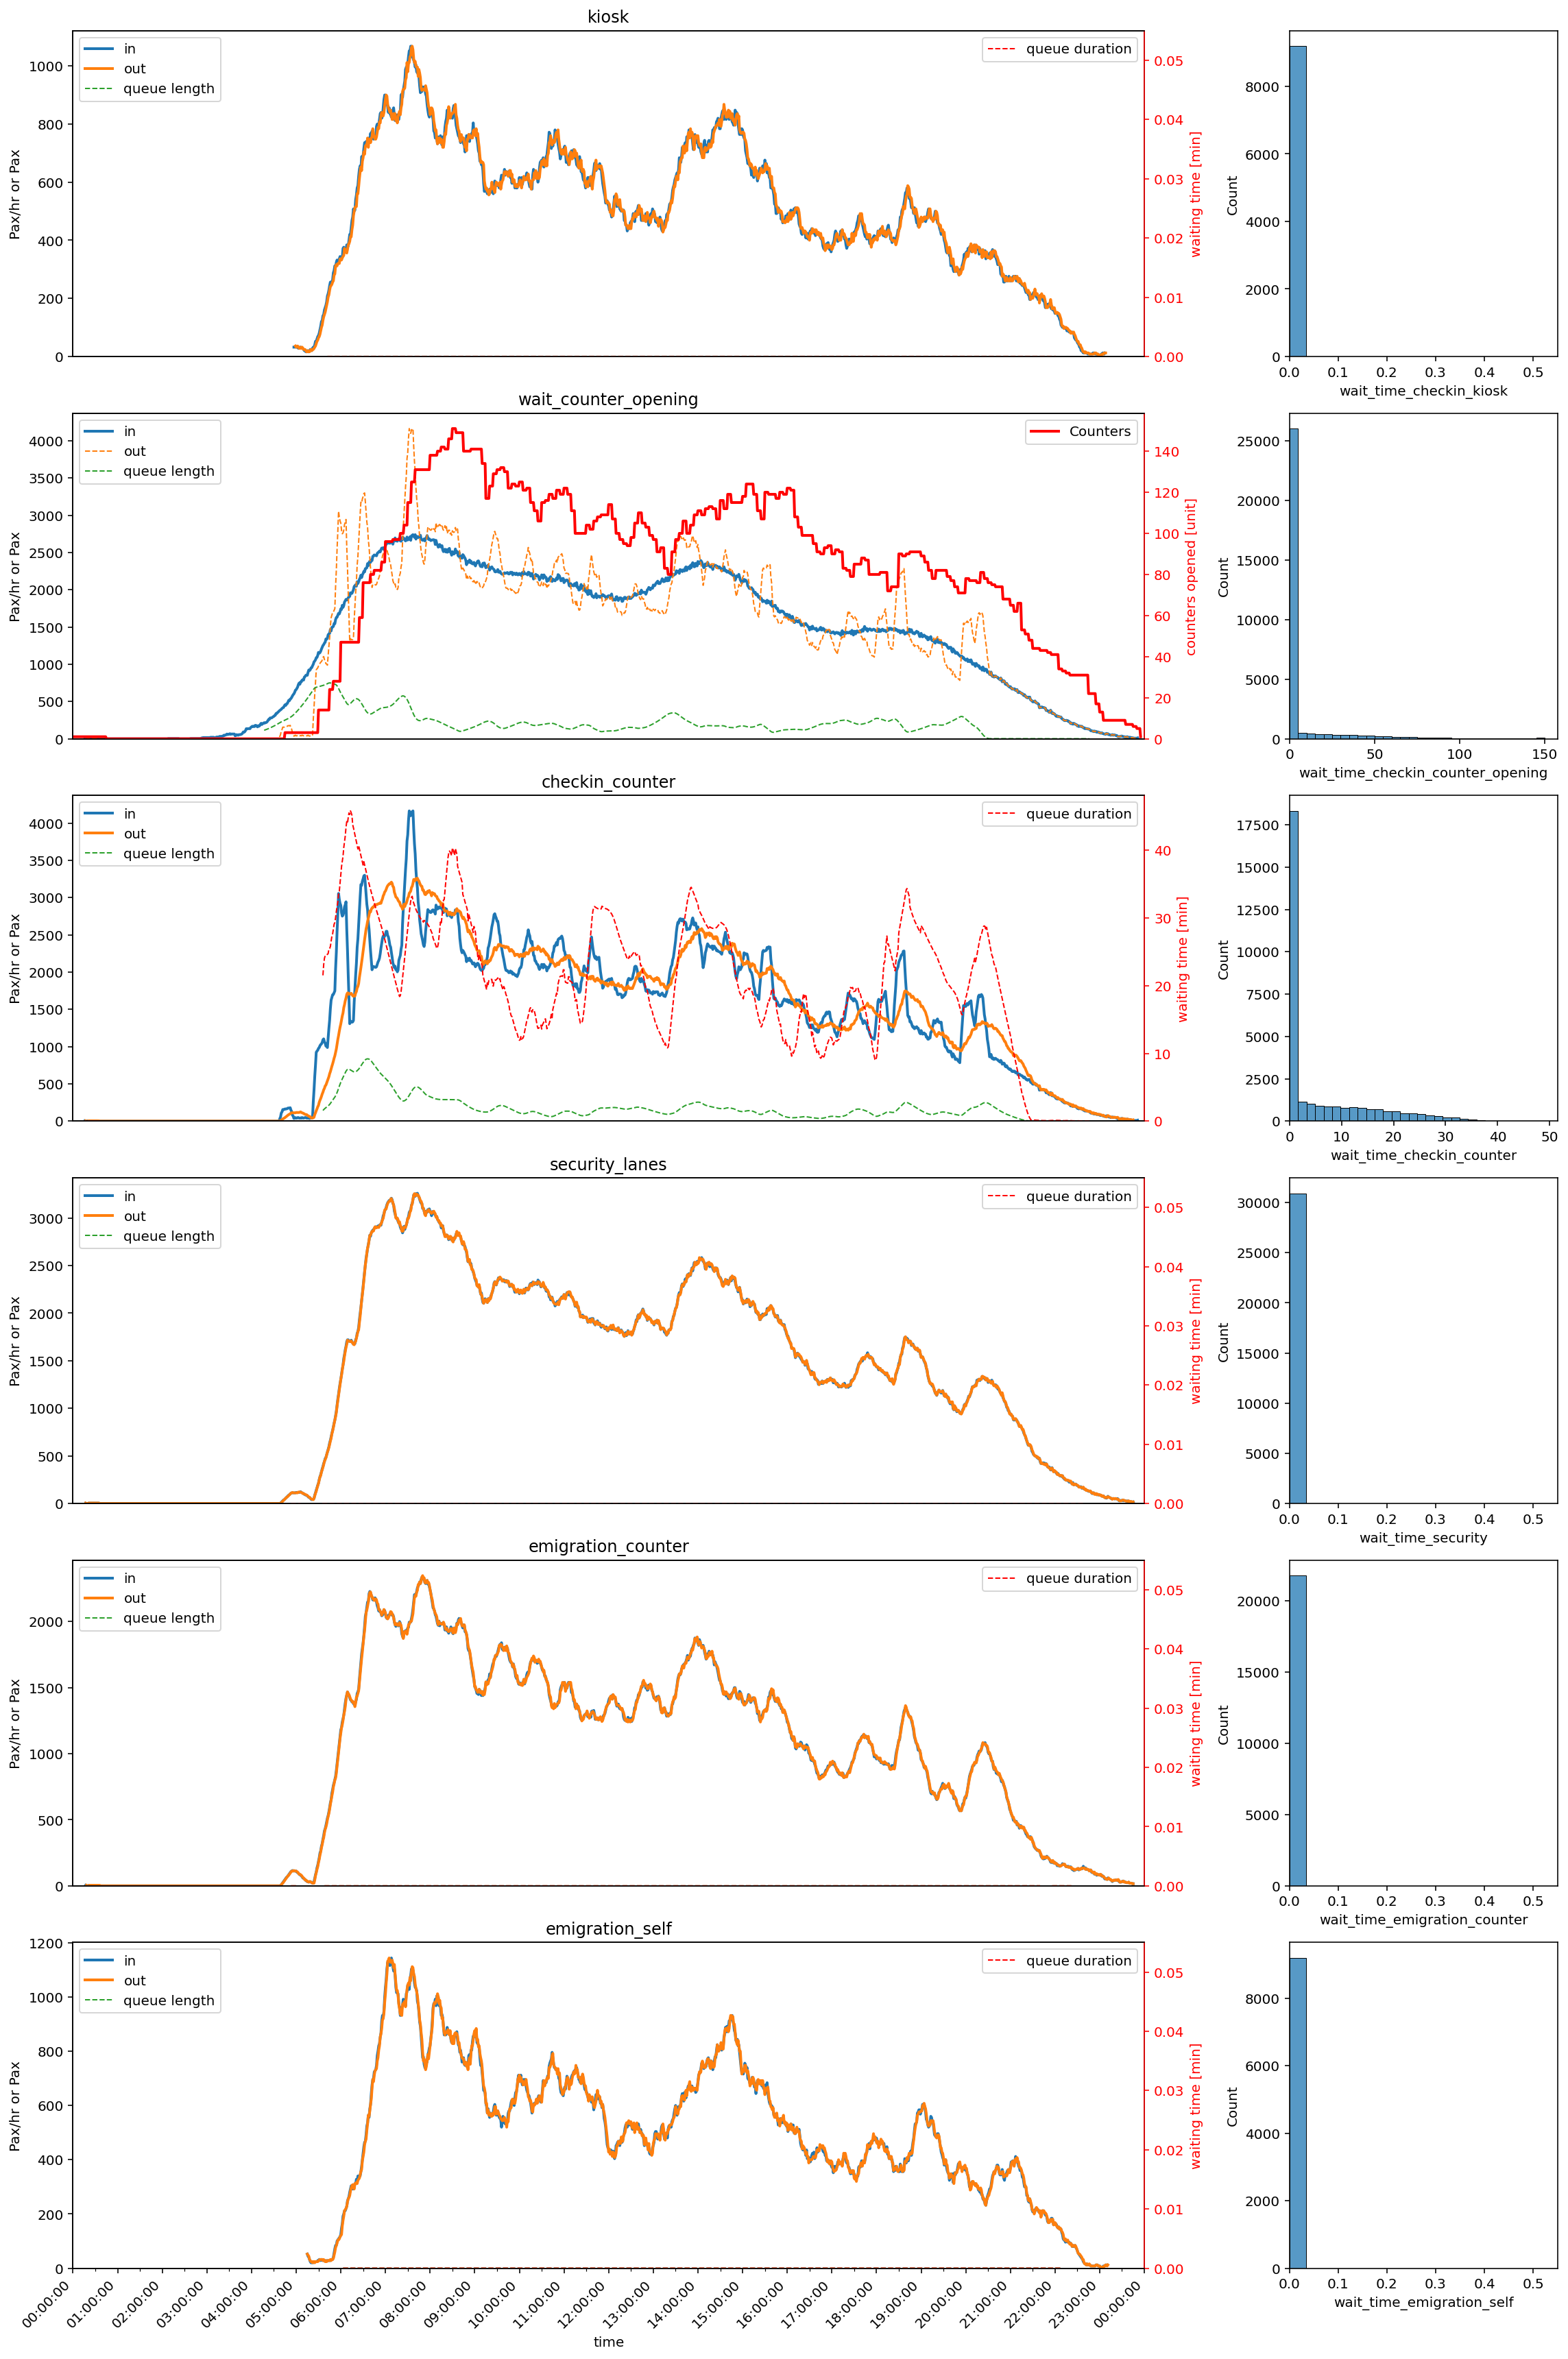

<IPython.core.display.Javascript object>

In [ ]:
for case in dct_df_Counters.keys():
    (
        dct_df_result[case],
        _,
        _,
        _,
    ) = KIX_T1d(**dct_df_param[case])

In [ ]:
df_result = dct_df_result["2.5"]
df_result2 = dct_df_result["3"]
df_result3 = dct_df_result["3.5"]

df_Counters = dct_df_Counters["2.5"]
df_Counters2 = dct_df_Counters["3"]
df_Counters3 = dct_df_Counters["3.5"]

<IPython.core.display.Javascript object>

# focus on one airline

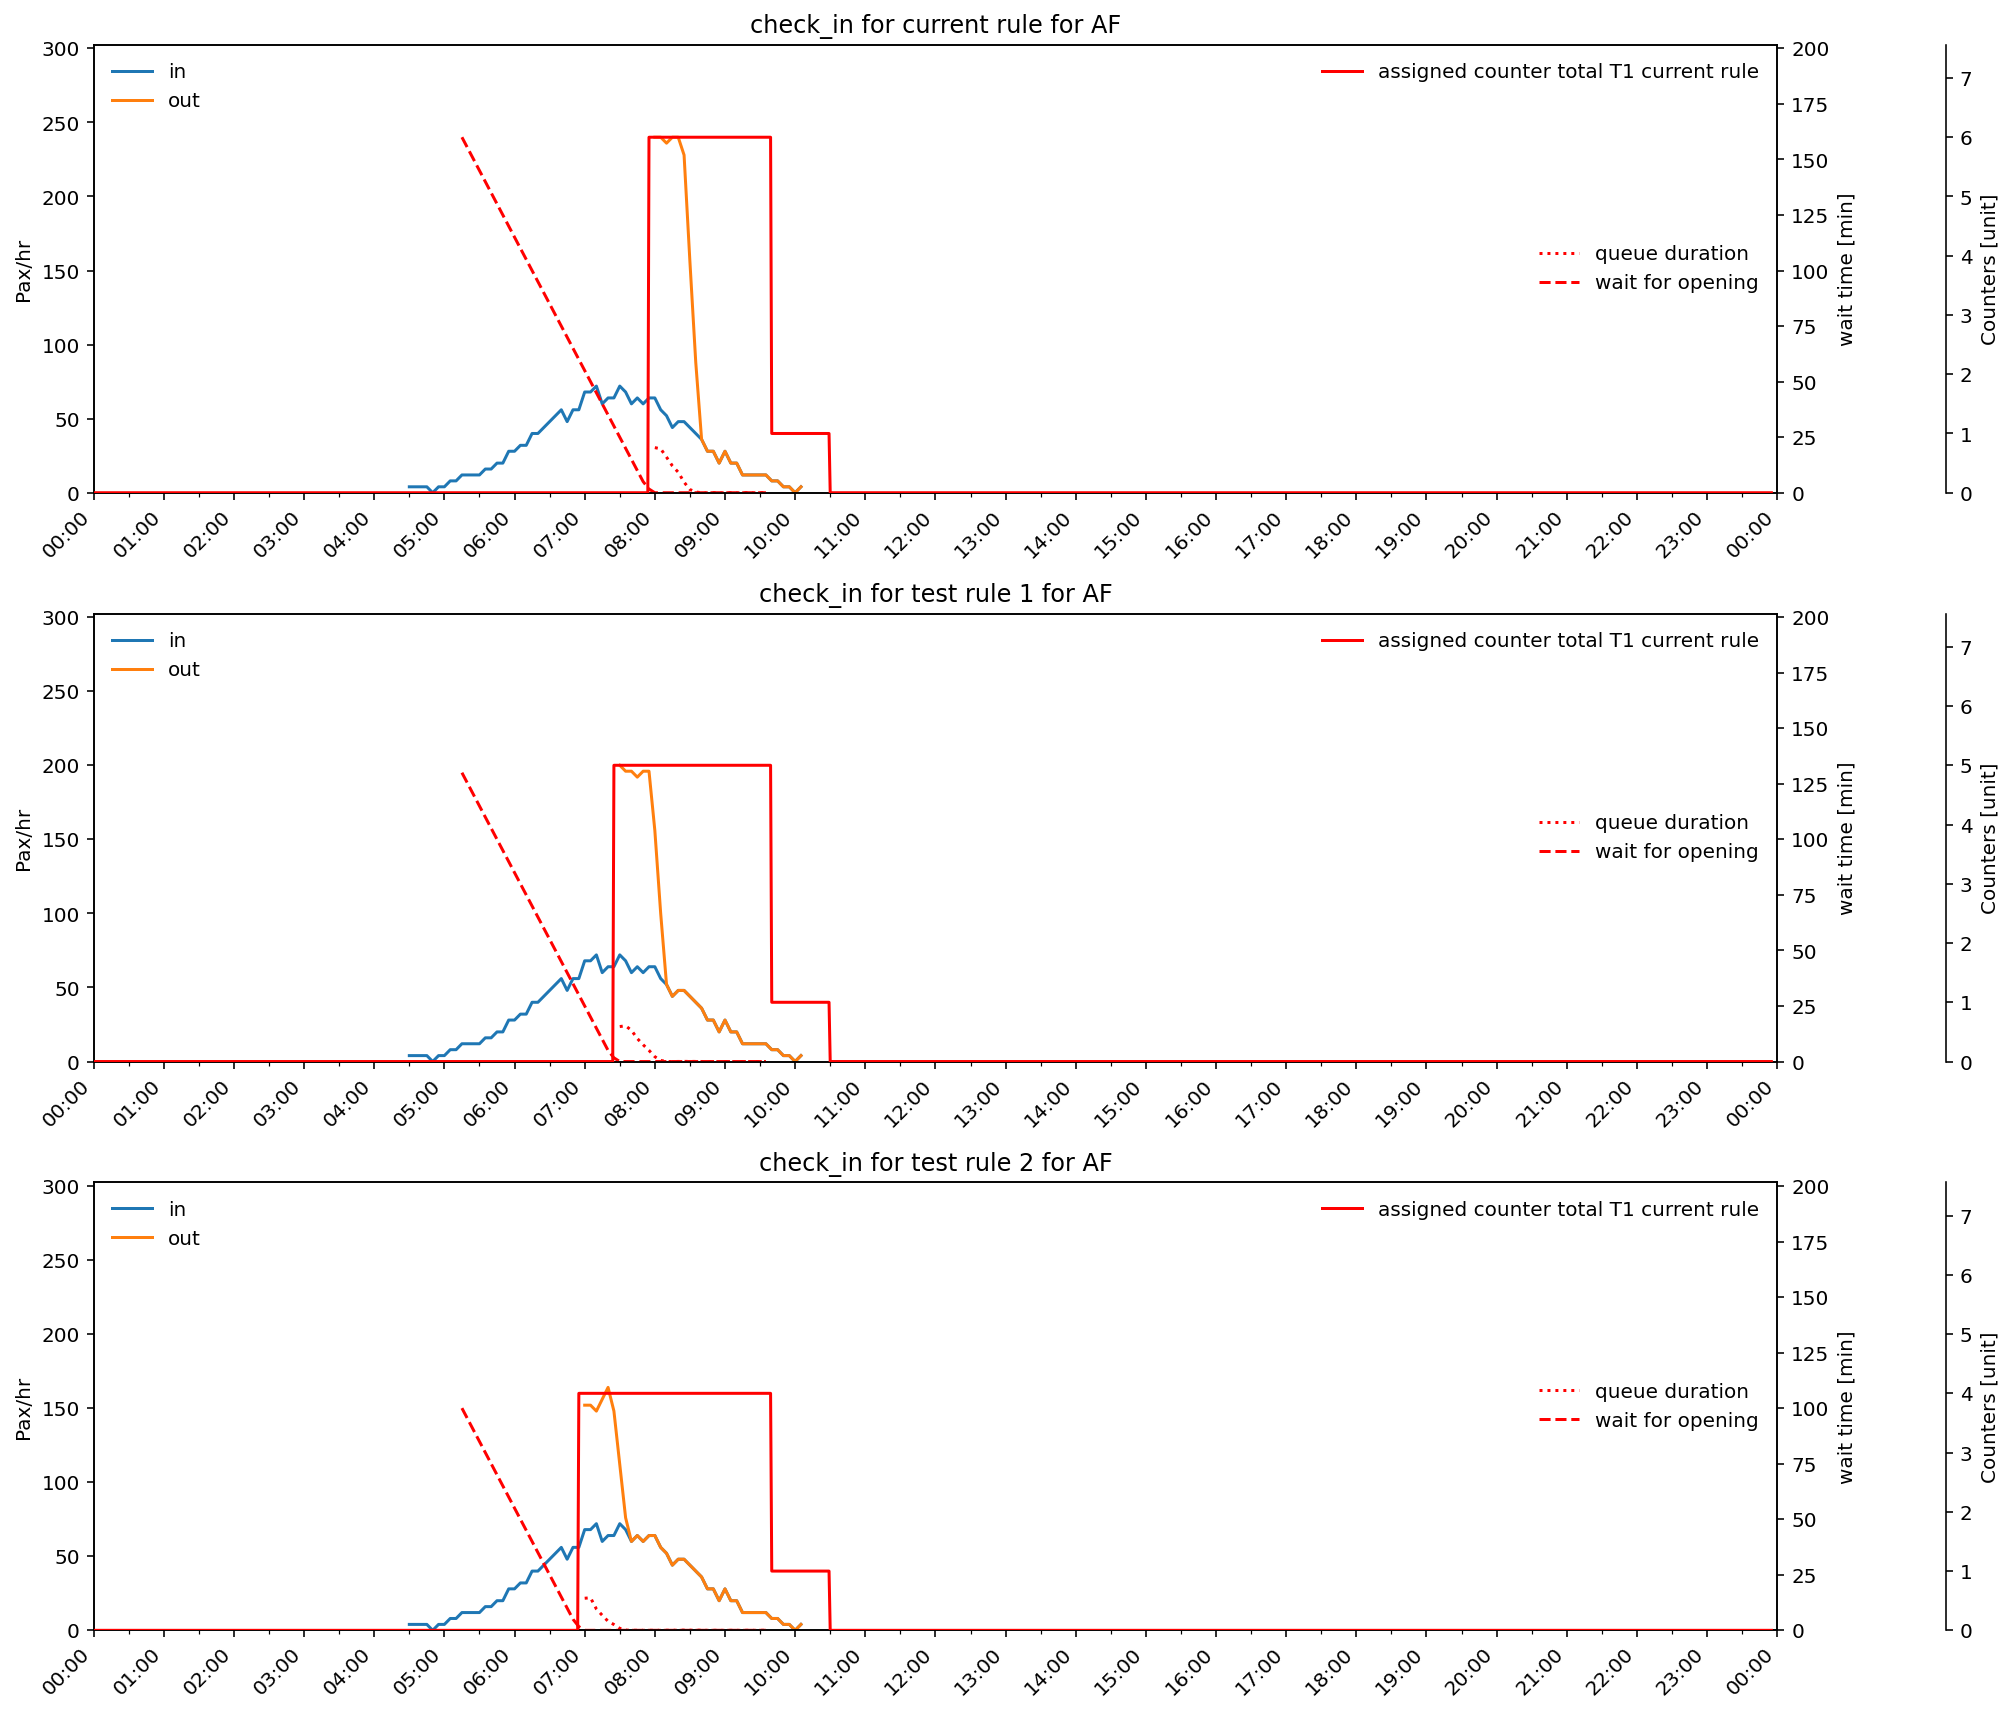

<IPython.core.display.Javascript object>

In [ ]:
airline = "AF"

mask_airline = df_result["flight_number"].apply(lambda x: x[0:2]) == airline

FREQ = "5min"
WINDOW = 3
ratio_sampling = pd.to_timedelta("1H") / pd.to_timedelta(FREQ)
# ============================= current rule =========================================
df_result["N_Pax"] = 1

plot_wait_opening_airline = (
    df_result[mask_airline]
    .set_index("start_wait_for_counter_opening", drop=False)[
        "wait_time_checkin_counter_opening"
    ]
    .apply(lambda x: x.total_seconds() / 60)
    .resample(FREQ)
    .agg(["mean"])
    .rolling(window=WINDOW, center=True)
    .mean()
)

plot_wait_airline = (
    df_result[mask_airline]
    .set_index("start_checkin_counter_queue", drop=False)["wait_time_checkin_counter"]
    .apply(lambda x: x.total_seconds() / 60)
    .resample(FREQ)
    .agg(["mean"])
    .rolling(window=WINDOW, center=True)
    .mean()
)


plot_in_airline = (
    df_result[mask_airline]
    .set_index("start_wait_for_counter_opening", drop=False)["N_Pax"]
    .resample(FREQ)
    .agg(["sum"])
    .rolling(window=WINDOW, center=True)
    .mean()
    .apply(lambda x: x * ratio_sampling)
)


plot_out_airline = (
    df_result[mask_airline]
    .set_index("end_checkin_counter_queue", drop=False)["N_Pax"]
    .resample(FREQ)
    .agg(["sum"])
    .rolling(window=WINDOW, center=True)
    .mean()
    .apply(lambda x: x * ratio_sampling)
)

data_counters_airline = df_Counters[[airline]].copy()

# Plot des counters
data_counters_airline["time"] = data_counters_airline.index
data_counters_airline["time"] = data_counters_airline["time"].apply(
    lambda x: minutes_to_hms(5 * x)
)
data_counters_airline["time"] = pd.to_datetime(data_counters_airline["time"])
plot_counter_airline = (
    data_counters_airline.set_index("time").resample("60S").ffill()[[airline]]
)

# plot param
xmin = pd.to_datetime("2020-10-13 00:00:00")
xmax = pd.to_datetime("2020-10-14 00:00:00")
plt.rcParams.update({"figure.autolayout": True})
hours = mdates.HourLocator(interval=1)
half_hours = mdates.MinuteLocator(byminute=[0, 30], interval=1)
h_fmt = mdates.DateFormatter("%H:%M")

# actual plotting
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 12))
ax2 = [ax[i].twinx() for i in range(3)]
ax3 = [ax[i].twinx() for i in range(3)]

ax[0].plot(
    plot_in_airline.index.to_list(),
    plot_in_airline["sum"],
    label="in",
)

ax[0].plot(
    plot_out_airline.index.to_list(),
    plot_out_airline["sum"],
    label="out",
)

ax2[0].plot(
    plot_wait_airline.index.to_list(),
    plot_wait_airline["mean"],
    label="queue duration",
    color="red",
    ls=":",
)

ax2[0].plot(
    plot_wait_opening_airline.index.to_list(),
    plot_wait_opening_airline["mean"],
    label="wait for opening",
    color="red",
    ls="--",
)

ax3[0].plot(
    plot_counter_airline.index.to_list(),
    plot_counter_airline[airline].to_list(),
    label="assigned counter total T1 current rule",
    color="red",
)

# formatting
ax[0].set_xlim((xmin, xmax))
ax[0].set(ylabel="Pax/hr")
ax[0].set_xticks(plot_in_airline.index.to_list())
ax[0].set_xticklabels(
    ax[0].get_xticks(), rotation=45, **{"horizontalalignment": "right"}
)
ax[0].xaxis.set_major_locator(hours)
ax[0].xaxis.set_major_formatter(h_fmt)
ax[0].xaxis.set_minor_locator(half_hours)
ax[0].legend(loc="upper left", frameon=False)
ax2[0].legend(loc="center right", frameon=False)
ax3[0].legend(loc="upper right", frameon=False)
ax3[0].tick_params(axis="y", which="both", bottom=False, top=False)

ax[0].set_title("check_in for current rule for {}".format(airline), fontsize=12)


# ============================= test rule 1 =========================================

mask_airline = df_result2["flight_number"].apply(lambda x: x[0:2]) == airline

FREQ = "5min"
WINDOW = 3

df_result2["N_Pax"] = 1

plot_wait_opening_airline = (
    df_result2[mask_airline]
    .set_index("start_wait_for_counter_opening", drop=False)[
        "wait_time_checkin_counter_opening"
    ]
    .apply(lambda x: x.total_seconds() / 60)
    .resample(FREQ)
    .agg(["mean"])
    .rolling(window=WINDOW, center=True)
    .mean()
)

plot_wait_airline = (
    df_result2[mask_airline]
    .set_index("start_checkin_counter_queue", drop=False)["wait_time_checkin_counter"]
    .apply(lambda x: x.total_seconds() / 60)
    .resample(FREQ)
    .agg(["mean"])
    .rolling(window=WINDOW, center=True)
    .mean()
)


plot_in_airline = (
    df_result2[mask_airline]
    .set_index("start_wait_for_counter_opening", drop=False)["N_Pax"]
    .resample(FREQ)
    .agg(["sum"])
    .rolling(window=WINDOW, center=True)
    .mean()
    .apply(lambda x: x * ratio_sampling)
)


plot_out_airline = (
    df_result2[mask_airline]
    .set_index("end_checkin_counter_queue", drop=False)["N_Pax"]
    .resample(FREQ)
    .agg(["sum"])
    .rolling(window=WINDOW, center=True)
    .mean()
    .apply(lambda x: x * ratio_sampling)
)

data_counters_airline = df_Counters2[[airline]].copy()
# Plot des counters
data_counters_airline["time"] = data_counters_airline.index
data_counters_airline["time"] = data_counters_airline["time"].apply(
    lambda x: minutes_to_hms(5 * x)
)
data_counters_airline["time"] = pd.to_datetime(data_counters_airline["time"])
plot_counter_airline = (
    data_counters_airline.set_index("time").resample("60S").ffill()[[airline]]
)

# actual plotting


ax[1].plot(
    plot_in_airline.index.to_list(),
    plot_in_airline["sum"],
    label="in",
)

ax[1].plot(
    plot_out_airline.index.to_list(),
    plot_out_airline["sum"],
    label="out",
)

ax2[1].plot(
    plot_wait_airline.index.to_list(),
    plot_wait_airline["mean"],
    label="queue duration",
    color="red",
    ls=":",
)

ax2[1].plot(
    plot_wait_opening_airline.index.to_list(),
    plot_wait_opening_airline["mean"],
    label="wait for opening",
    color="red",
    ls="--",
)

ax3[1].plot(
    plot_counter_airline.index.to_list(),
    plot_counter_airline[airline].to_list(),
    label="assigned counter total T1 current rule",
    color="red",
)

# formatting
ax[1].set_xlim((xmin, xmax))
ax[1].set(ylabel="Pax/hr")
ax[1].set_xticks(plot_in_airline.index.to_list())
ax[1].set_xticklabels(
    ax[1].get_xticks(), rotation=45, **{"horizontalalignment": "right"}
)
ax[1].xaxis.set_major_locator(hours)
ax[1].xaxis.set_major_formatter(h_fmt)
ax[1].xaxis.set_minor_locator(half_hours)
ax[1].legend(loc="upper left", frameon=False)
ax2[1].legend(loc="center right", frameon=False)
ax3[1].legend(loc="upper right", frameon=False)
ax3[1].tick_params(axis="y", which="both", bottom=False, top=False)

ax[1].set_title("check_in for test rule 1 for {}".format(airline), fontsize=12)

# ============================= test rule 2 =========================================


mask_airline = df_result3["flight_number"].apply(lambda x: x[0:2]) == airline

FREQ = "5min"
WINDOW = 3

df_result3["N_Pax"] = 1

plot_wait_opening_airline = (
    df_result3[mask_airline]
    .set_index("start_wait_for_counter_opening", drop=False)[
        "wait_time_checkin_counter_opening"
    ]
    .apply(lambda x: x.total_seconds() / 60)
    .resample(FREQ)
    .agg(["mean"])
    .rolling(window=WINDOW, center=True)
    .mean()
)

plot_wait_airline = (
    df_result3[mask_airline]
    .set_index("start_checkin_counter_queue", drop=False)["wait_time_checkin_counter"]
    .apply(lambda x: x.total_seconds() / 60)
    .resample(FREQ)
    .agg(["mean"])
    .rolling(window=WINDOW, center=True)
    .mean()
)


plot_in_airline = (
    df_result3[mask_airline]
    .set_index("start_wait_for_counter_opening", drop=False)["N_Pax"]
    .resample(FREQ)
    .agg(["sum"])
    .rolling(window=WINDOW, center=True)
    .mean()
    .apply(lambda x: x * ratio_sampling)
)


plot_out_airline = (
    df_result3[mask_airline]
    .set_index("end_checkin_counter_queue", drop=False)["N_Pax"]
    .resample(FREQ)
    .agg(["sum"])
    .rolling(window=WINDOW, center=True)
    .mean()
    .apply(lambda x: x * ratio_sampling)
)

data_counters_airline = df_Counters3[[airline]].copy()
# Plot des counters
data_counters_airline["time"] = data_counters_airline.index
data_counters_airline["time"] = data_counters_airline["time"].apply(
    lambda x: minutes_to_hms(5 * x)
)
data_counters_airline["time"] = pd.to_datetime(data_counters_airline["time"])
plot_counter_airline = (
    data_counters_airline.set_index("time").resample("60S").ffill()[[airline]]
)


# actual plotting
ax[2].plot(
    plot_in_airline.index.to_list(),
    plot_in_airline["sum"],
    label="in",
)

ax[2].plot(
    plot_out_airline.index.to_list(),
    plot_out_airline["sum"],
    label="out",
)

ax2[2].plot(
    plot_wait_airline.index.to_list(),
    plot_wait_airline["mean"],
    label="queue duration",
    color="red",
    ls=":",
)

ax2[2].plot(
    plot_wait_opening_airline.index.to_list(),
    plot_wait_opening_airline["mean"],
    label="wait for opening",
    color="red",
    ls="--",
)

ax3[2].plot(
    plot_counter_airline.index.to_list(),
    plot_counter_airline[airline].to_list(),
    label="assigned counter total T1 current rule",
    color="red",
)

# formatting
ax[2].set_xlim((xmin, xmax))
ax[2].set(ylabel="Pax/hr")
ax[2].set_xticks(plot_in_airline.index.to_list())
ax[2].set_xticklabels(
    ax[2].get_xticks(), rotation=45, **{"horizontalalignment": "right"}
)
ax[2].xaxis.set_major_locator(hours)
ax[2].xaxis.set_major_formatter(h_fmt)
ax[2].xaxis.set_minor_locator(half_hours)
ax[2].legend(loc="upper left", frameon=False)
ax2[2].legend(loc="center right", frameon=False)
ax3[2].legend(loc="upper right", frameon=False)
ax3[2].tick_params(axis="y", which="both", bottom=False, top=False)

ax[2].set_title("check_in for test rule 2 for {}".format(airline), fontsize=12)

# list of top ylims
top_list = []
top2_list = []
top3_list = []

# get all the yop ylim for each axes
for i in range(3):
    _, top = ax[i].get_ylim()
    _, top2 = ax2[i].get_ylim()
    _, top3 = ax3[i].get_ylim()
    # append to the list
    top_list.append(top)
    top2_list.append(top2)
    top3_list.append(top3)

# use max for all
for i in range(3):
    top = max(top_list)
    top2 = max(top2_list)
    top3 = max(top3_list)

    newtop = 1.20 * top
    ax[i].set_ylim(bottom=0, top=newtop)
    newtop2 = 1.20 * top2
    ax2[i].set_ylim(bottom=0, top=newtop2)
    newtop3 = 1.20 * top3
    ax3[i].set_ylim(bottom=0, top=newtop3)


def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


for i in range(3):
    ax3[i].spines["right"].set_position(("axes", 1.1))
    make_patch_spines_invisible(ax3[i])
    ax3[i].spines["right"].set_visible(True)
    ax3[i].set(ylabel="Counters [unit]")
    ax2[i].set(ylabel="wait time [min]")

# Show results for whole departures

In [ ]:
# filter the 10 weird Pax...
mask2 = (
    df_result2["wait_time_checkin_counter"].apply(lambda x: x.total_seconds() / 60)
    < 100
)

mask3 = (
    df_result3["wait_time_checkin_counter"].apply(lambda x: x.total_seconds() / 60)
    < 100
)

<IPython.core.display.Javascript object>

In [ ]:
FREQ = "5min"
WINDOW = 3

plot1 = (
    df_result.set_index("start_checkin_counter_queue", drop=False)[
        "wait_time_checkin_counter"
    ]
    .apply(lambda x: x.total_seconds() / 60)
    .resample(FREQ)
    .agg(["max"])
    .rolling(window=WINDOW, center=True)
    .mean()
)


plot2 = (
    df_result2[mask2]
    .set_index("start_checkin_counter_queue", drop=False)["wait_time_checkin_counter"]
    .apply(lambda x: x.total_seconds() / 60)
    .resample(FREQ)
    .agg(["max"])
    .rolling(window=WINDOW, center=True)
    .mean()
)


plot3 = (
    df_result3[mask3]
    .set_index("start_checkin_counter_queue", drop=False)["wait_time_checkin_counter"]
    .apply(lambda x: x.total_seconds() / 60)
    .resample(FREQ)
    .agg(["max"])
    .rolling(window=WINDOW, center=True)
    .mean()
)

<IPython.core.display.Javascript object>

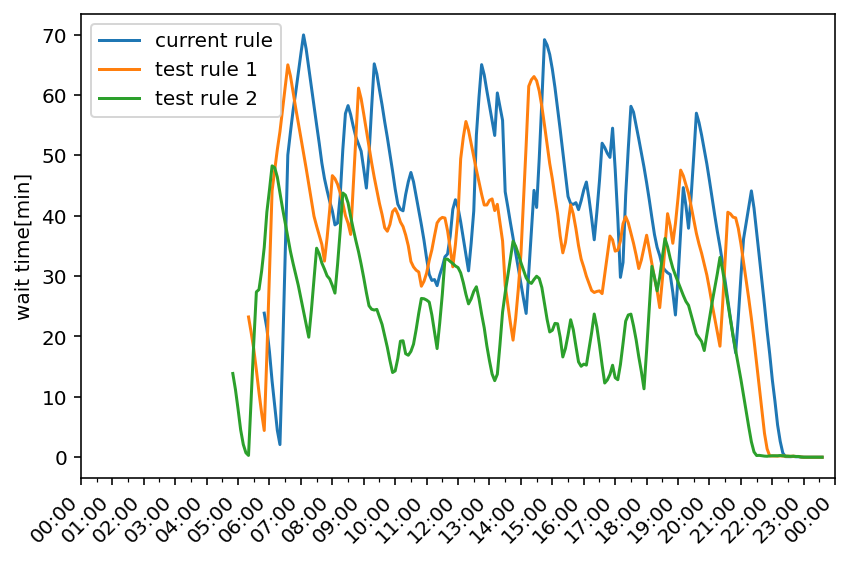

<IPython.core.display.Javascript object>

In [ ]:
# plot param
xmin = pd.to_datetime("2020-10-13 00:00:00")
xmax = pd.to_datetime("2020-10-14 00:00:00")
plt.rcParams.update({"figure.autolayout": True})
hours = mdates.HourLocator(interval=1)
half_hours = mdates.MinuteLocator(byminute=[0, 30], interval=1)
h_fmt = mdates.DateFormatter("%H:%M")

fig, ax = plt.subplots()
ax.plot(plot1, label="current rule")
ax.plot(plot2, label="test rule 1")
ax.plot(plot3, label="test rule 2")
ax.legend(frameon=False, loc="upper left")

# formatting
ax.set_xlim((xmin, xmax))
ax.set_xticks(plot1.index.to_list())
ax.set_xticklabels(ax.get_xticks(), rotation=45, **{"horizontalalignment": "right"})
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
ax.xaxis.set_minor_locator(half_hours)
ax.set(ylabel="wait time[min]")
ax.legend(loc="upper left")

In [ ]:
a = (
    df_result["wait_time_checkin_counter"]
    .apply(lambda x: x.total_seconds() / 60)
    .to_list()
)
b = (
    df_result2[mask2]["wait_time_checkin_counter"]
    .apply(lambda x: x.total_seconds() / 60)
    .to_list()
)
c = (
    df_result3[mask3]["wait_time_checkin_counter"]
    .apply(lambda x: x.total_seconds() / 60)
    .to_list()
)

dct_hist_rules = {
    "current rule": a,
    "test rule 1": b,
    "test rule 2": c,
}
df_hist_rules = pd.DataFrame.from_dict(dct_hist_rules, orient="index").transpose()

<IPython.core.display.Javascript object>

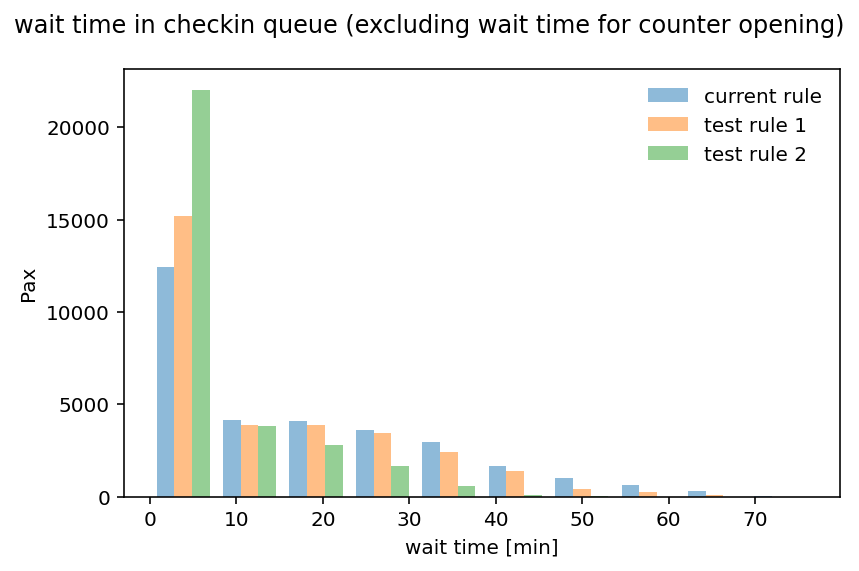

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots()
ax.hist(
    df_hist_rules,
    alpha=0.5,
    label=["current rule", "test rule 1", "test rule 2"],
)
ax.set(ylabel="Pax", xlabel="wait time [min]")
ax.legend(frameon=False)
fig.suptitle("wait time in checkin queue (excluding wait time for counter opening)")
plt.show()